<a href="https://colab.research.google.com/github/prathameshbadve/UAV/blob/main/UAV_SIR_Particle_Filter_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import xlrd
import time

In [ ]:
#Extractind data from excel sheet into a dataframe

df = pd.read_excel(r'/content/drive/MyDrive/Research/UAV Project/trajectory_data1.xlsx', sheet_name='Sheet1')
data = np.array(df)

print(data.shape)
print(data[0:2])

(48, 3)
[[ 37.1966334 -80.5763417 632.75     ]
 [ 37.1965847 -80.5764513 633.22     ]]


In [ ]:
df.head(10)

,Latitude,Longitude,Altitude
0,37.196633,-80.576342,632.75
1,37.196585,-80.576451,633.22
2,37.196532,-80.576554,632.59
3,37.196473,-80.576648,631.97
4,37.196424,-80.576749,631.03
5,37.196427,-80.576876,628.64
6,37.196501,-80.576992,626.12
7,37.196621,-80.577068,625.34
8,37.196744,-80.577136,625.69
9,37.196858,-80.577210,626.26


In [ ]:
#Generating the initial instantaneous velocities

velocity = np.diff(data, axis=0)
temp = np.zeros((1, 3))
velocity = np.concatenate((temp, velocity))

print(velocity.shape)
print(velocity[0:2])

(48, 3)
[[ 0.000e+00  0.000e+00  0.000e+00]
 [-4.870e-05 -1.096e-04  4.700e-01]]


In [ ]:
data = np.concatenate((data, velocity), axis=1)
print(data.shape)
print(data[0:2])

(48, 6)
[[ 3.71966334e+01 -8.05763417e+01  6.32750000e+02  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.71965847e+01 -8.05764513e+01  6.33220000e+02 -4.87000000e-05
  -1.09600000e-04  4.70000000e-01]]


In [ ]:
measurements = data[:, :3]
print(measurements.shape)

(48, 3)


In [ ]:
#Initializing the problem

N = 2500                              # Number of particles
train_window = 15
T = len(data)
c = 0.8

x = data[train_window-1, :].reshape((6, 1))                               # x stores the latest position of the system

process_noise_mean = 0              # Process noise
measure_noise_mean = 0              # Measurement noise

process_noise_cov = np.var(data[0:train_window, :], axis=0)
measure_noise_cov = np.diag(process_noise_cov[0:3])*(1-c)
process_noise_cov = np.diag(process_noise_cov)*c

particles = np.zeros((N, 6))             # This array will keep track of the particles at every time step
particle_weights = np.zeros(N)      # This array will keep track of the weights of the corresponding particles

x_hist = []                         # To store the history of the state
z_hist = []                         # To store the history of the measurements
est_hist = []                       # To store the history of the estimates made by the particle filter
lq_hist = []
uq_hist = []
particle_hist = []
time_hist = []
unique = []

parent = np.zeros(N)

print(x.shape)
print(process_noise_cov.shape)
print(measure_noise_cov.shape)
print(particles.shape)

(6, 1)
(6, 6)
(3, 3)
(2500, 6)


In [ ]:
#Process Equation for prediction step

delT = 1
A = np.array([[1, 0, 0, delT, 0, 0], [0, 1, 0, 0, delT, 0], [0, 0, 1, 0, 0, delT], [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])

def process_function(x_k):
    new_particles = np.zeros((N, 6))
    for i in range(x_k.shape[0]):
        mean = np.dot(A, x_k[i, :].T)
        new_particle = np.random.multivariate_normal(mean=mean.reshape(6, ), cov=process_noise_cov)
        new_particles[i, :] = new_particle
    return new_particles

In [ ]:
#Measurement equation for update step

C = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

def likelihood(x_k, z):
    weights = np.zeros(N)
    for i in range(x_k.shape[0]):
        mean = np.dot(C, x_k[i, :].T).reshape((3, 1))
        temp = np.linalg.inv(measure_noise_cov)
        kernel = np.dot((z - mean).T, temp)
        kernel = np.dot(kernel, (z - mean))
        log_like = -0.5*kernel -0.5*np.log(np.linalg.det(measure_noise_cov)) -1.5*np.log(2*math.pi) 
        weights[i] = log_like
    weights = weights - np.max(weights)
    weights = np.exp(weights)
    return weights

In [ ]:
#Sampling particles for first step

for i in range(particles.shape[0]):
    particles[i, :] = np.random.multivariate_normal(mean=x.reshape((6,)), cov=process_noise_cov)

particle_hist.append(particles)

print(particles.shape)


(2500, 6)


In [ ]:
#Resampling algorithm

def resample(particles, particle_weights):
    parents = np.random.choice(range(len(particles)), N, p=particle_weights)
    resampled_particles = particles[parents]
    return resampled_particles, parents

In [ ]:
#Main Loop

for k in range(train_window, T):
    start = time.time()
    particles = process_function(particles)

    particle_weights = likelihood(particles, measurements[k, :].reshape((3, 1)))

    total = np.sum(particle_weights)                            # t is the normalizing constant
    particle_weights = particle_weights / total                 # Normalizing the weights

    particles, parents = resample(particles, particle_weights)

    for i in range(N):
        particle_weights[i] = 1/N

    estimate = np.mean(particles, axis=0)

    particle_hist.append(particles)
    est_hist.append(estimate)
    
    lq_hist.append(np.quantile(particles, 0.025, axis=0)[0:3])
    uq_hist.append(np.quantile(particles, 0.975, axis=0)[0:3])

    process_noise_cov = np.var(data[k+1-train_window:k+1, :], axis=0)
    measure_noise_cov = np.diag(process_noise_cov[0:3])*(1-c)
    process_noise_cov = np.diag(process_noise_cov)*c

    unique.append(np.unique(particles, axis=0).shape[0])

    end = time.time()
    time_hist.append(end-start)

In [ ]:
estimate_history = np.array(est_hist)
print(estimate_history.shape)

lower_quant = np.array(lq_hist)
up_quant = np.array(uq_hist)
print(lower_quant.shape)
print(up_quant.shape)

new_measure = measurements[15:, :]
print(new_measure.shape)

(33, 6)
(33, 3)
(33, 3)
(33, 3)


In [ ]:
new_measure = measurements[15:, :]
print(new_measure.shape)

(33, 3)


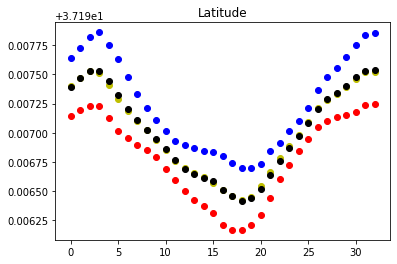

In [ ]:
plt.plot(new_measure[:, 0].T, 'yo')
plt.plot(estimate_history[:, 0].T, 'ko')
plt.plot(lower_quant[:, 0].T, 'ro')
plt.plot(up_quant[:, 0].T, 'bo')
plt.title("Latitude")
plt.show()

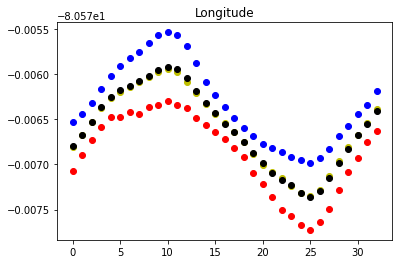

In [ ]:
plt.plot(new_measure[:, 1].T, 'yo')
plt.plot(estimate_history[:, 1].T, 'ko')
plt.plot(lower_quant[:, 1].T, 'ro')
plt.plot(up_quant[:, 1].T, 'bo')
plt.title("Longitude")
plt.show()

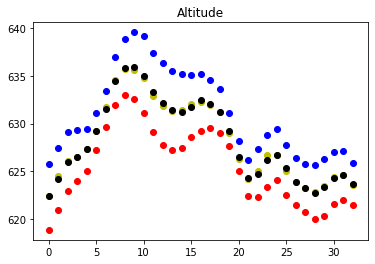

In [ ]:
plt.plot(new_measure[:, 2].T, 'yo')
plt.plot(estimate_history[:, 2].T, 'ko')
plt.plot(lower_quant[:, 2].T, 'ro')
plt.plot(up_quant[:, 2].T, 'bo')
plt.title("Altitude")
plt.show()

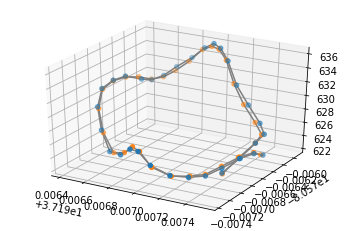

In [ ]:
ax = plt.axes(projection='3d')
ax.scatter3D(estimate_history[:, 0].T, estimate_history[:, 1].T, estimate_history[:, 2].T)
ax.plot3D(estimate_history[:, 0], estimate_history[:, 1], estimate_history[:, 2], 'gray')
ax.scatter3D(new_measure[:, 0], new_measure[:, 1], new_measure[:, 2])
ax.plot3D(new_measure[:, 0], new_measure[:, 1], new_measure[:, 2], 'gray')

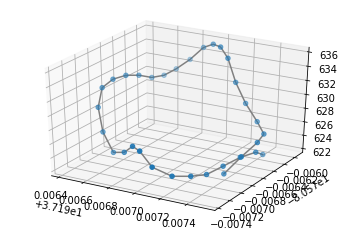

In [ ]:
ax = plt.axes(projection='3d')
ax.scatter3D(new_measure[:, 0], new_measure[:, 1], new_measure[:, 2])
ax.plot3D(new_measure[:, 0], new_measure[:, 1], new_measure[:, 2], 'gray')

In [ ]:
estimated_particles = particle_hist[1:]

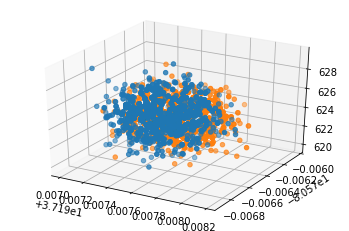

In [ ]:
ax = plt.axes(projection='3d')
ax.scatter3D(estimated_particles[-2][:, 0], estimated_particles[-2][:, 1], estimated_particles[-2][:, 2])
ax.scatter3D(estimated_particles[-1][:, 0], estimated_particles[-1][:, 1], estimated_particles[-1][:, 2])


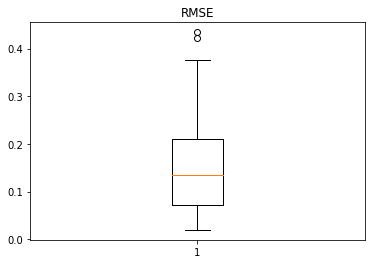

In [ ]:
rmse = []

for i in range(len(new_measure)):
    rmse.append(np.sqrt(np.sum((estimate_history[i, 0:3] - new_measure[i])**2)))

plt.boxplot(rmse)
plt.title("RMSE")
plt.show()

In [ ]:
error = 0
for i in rmse:
    error = error + i**2

error = (error / len(rmse))**0.5
print(error)

0.19750179944256216


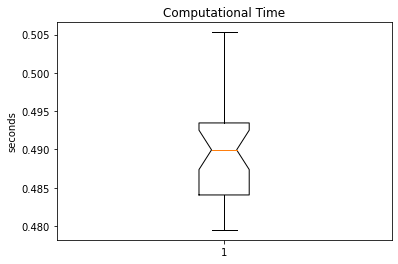

In [ ]:
plt.boxplot(time_hist, 'o')
plt.title('Computational Time')
plt.ylabel('seconds')
plt.show()

In [ ]:
results = np.concatenate((estimate_history[:, :3], lower_quant, up_quant, new_measure), axis=1)

In [ ]:
df1 = pd.DataFrame(results)

In [ ]:
df1.to_excel("/content/drive/My Drive/Research/UAV Project/datasetT1_sir.xlsx", sheet_name="Sheet1", header=False, index=False)

In [ ]:
print(unique)

[470, 598, 574, 553, 473, 456, 454, 506, 504, 543, 501, 524, 522, 501, 519, 493, 510, 484, 478, 446, 399, 484, 445, 447, 477, 518, 500, 521, 495, 519, 497, 493, 460]
